In [1]:
""""
This part is some explotary analysis for the Listing Dojo data
""""

import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_columns = 100

import pandas as pd
import sys
import os
import time
from datetime import datetime
from datetime import timedelta  
# sys.path.insert(0,'../')
# from importlib import reload
# import PWLib
# reload(PWLib)

from glob import glob
import os
from os import listdir
from os.path import isfile, join
import json

import urllib
# sys.path.insert(0,r'Desktop\vl_code\DataScience')
sys.path.insert(0,'/user/zhaoyu/tree')

import numpy as np
from multiprocessing import Pool, current_process
from importlib import reload
import PWLib as PWLib
reload(PWLib)
from PWLib.VTracker import VTracker

vt_key='Input the VTracker API key here'

reload(PWLib)
from PWLib import AzureBlob
from PWLib import VL_Blobs
from PWLib.VL_Blobs import ASIN
from PWLib.Util import Util
from PWLib.Campaign import Campaign

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
import itertools
import seaborn as sns
import ast

account_name= "vlst"
account_key= "Input the VL blob API key here"

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

blob = ASIN(account_name,account_key)
marketplace = 'US'

import calendar
import re



In [77]:
from PIL import Image
import requests
from io import BytesIO
# from IPython.display import Image
from matplotlib.pyplot import imshow, show
%matplotlib inline
import cv2
import urllib.request

In [ ]:
# pip install dill
# Save a Notebook session:

# import dill
# dill.dump_session(‘notebook_env.db’)
# Restore a Notebook session:

# import dill
# dill.load_session(‘notebook_env.db’)

In [2]:
############ Read in the Dojo data
# dojo_data = json.loads('/ListingDojo/ListingDojoCampaigns_20190613.json')
with open('./ListingDojo/ListingDojoCampaigns_20190613.json', 'r') as file:
#     data = file.read().replace('\n', '')
    json_array = json.load(file)

In [3]:
######## Merge a list of dictionary to a dataframe
def merge_dicts_to_df(list_of_dicts):
    v_list = list_of_dicts
    data = v_list[0]
    df_asin = pd.DataFrame([data], columns=data.keys())
    if len(v_list) > 1:
        for i in range(1, len(v_list)):
            data = v_list[i]
            df_t = pd.DataFrame([data], columns=data.keys())
            df_asin = pd.concat([df_asin, df_t], axis=0, ignore_index=True, sort=False)
    return df_asin

In [4]:
dojo_df = merge_dicts_to_df(json_array)

In [7]:
dojo_df.head(2)

id   StartDate     EndDate  \
0  ListingDojoCampaign_US_B00QRYGRGE_A3N30XA068ZM...  2016-09-30  2016-10-08   
1  ListingDojoCampaign_US_B01N97ZS67_A2R8YPBUJ7B0...  2017-06-14  2017-07-12   

                                            Original  \
0  {'id': 'AmazonProduct_US_B00QRYGRGE_A3N30XA068...   
1  {'id': 'AmazonProduct_US_B01N97ZS67_A2R8YPBUJ7...   

                                          Variations  \
0  [{'ListingElement': 'Price', 'Duration': 7, 'V...   
1  [{'ListingElement': 'Price', 'Duration': 7, 'V...   

                                             Metrics  ProfitGain     Status  \
0  {'Price': [{'Days': 30, 'Option': 9.99, 'IsBes...         0.0    Stopped   
1  {'Price': [{'Days': 30, 'Option': 11.95, 'IsBe...         0.0  Completed   

         SellerID               SKU                   At          pk  \
0  A3N30XA068ZM66  NJ-TJ0P-OKCL-TPU  0001-01-01T00:00:00  B00QRYGRGE   
1  A2R8YPBUJ7B00O      ZL-M0P4-2Q7K  0001-01-01T00:00:00  B01N97ZS67   

         ASIN Marketplace                 Type  ParentASIN LastTouchedAt  \
0  B00QRYGRGE          US  ListingDojoCampaign         NaN           NaN   
1  B01N97ZS67          US  ListingDojoCampaign  B01MTQYMFZ           NaN   

   StarRating  
0         NaN  
1         NaN

In [5]:
dojo_df.shape

(9273, 18)

In [6]:
dojo_df['ASIN'].nunique()

6470

In [10]:
for i in range(len(dojo_df)):
    metrics = dojo_df['Metrics'][i]
    try:
        for k in metrics.keys():
            if k not in ['Price', 'Images', 'Title', 'Description']:
                print(k)
    except:
        pass

images
price
title
images


In [7]:
############ get pairs of price and profit
pair_ls_price = []
pair_ls_image = []
pair_ls_title = []
pair_ls_desc = []
for i in range(len(dojo_df)):
    metrics = dojo_df['Metrics'][i]
    try:
        if 'Price' in metrics.keys() or 'price' in metrics.keys():
            try:
                p_ls = metrics['Price']
            except:
                p_ls = metrics['price']
            p_dict = {}
            prices = []
            net_total = []
            net_organic = []
            delta_pct_total = []
            delta_pct_organic = []
            days = []
            for j in range(len(p_ls)):
                d = p_ls[j]
                prices.append(d['Option'])
                net_total.append(d['AverageNetTotal'])
                net_organic.append(d['AverageNetOrganic'])
                delta_pct_total.append(d['DeltaNetTotal']/(d['AverageNetTotal']-d['DeltaNetTotal']))
                delta_pct_organic.append(d['DeltaNetOrganic']/(d['AverageNetOrganic']-d['DeltaNetOrganic']))
                days.append(d['Days'])
            p_dict['id'] = dojo_df['id'][i]
            p_dict['Price'] = prices
            p_dict['AverageNetTotal'] = net_total
            p_dict['AverageNetOrganic'] = net_organic
            p_dict['Days'] = days
            pct_prices = [(x-prices[0])/prices[0] for x in prices]
            net_pros = [(x-net_total[0])/net_total[0] for x in net_total]
            p_dict['PercentPriceChange'] = pct_prices
            p_dict['PercentNetTotalChange'] = net_pros
            p_dict['VarianceOfNetTotal'] = np.var(net_total)
            p_dict['VarianceOfNetTotalPCT'] = np.var(net_pros)
            pair_ls_price.append(p_dict)
    except:
        pass
    try:
        if 'Images' in metrics.keys() or 'images' in metrics.keys():
            try:
                p_ls = metrics['Images']
            except:
                p_ls = metrics['images']
            p_dict = {}
            prices = []
            net_total = []
            net_organic = []
            delta_pct_total = []
            delta_pct_organic = []
            days = []
            for j in range(len(p_ls)):
                d = p_ls[j]
                prices.append(d['Option'])
                net_total.append(d['AverageNetTotal'])
                net_organic.append(d['AverageNetOrganic'])
                delta_pct_total.append(d['DeltaNetTotal']/(d['AverageNetTotal']-d['DeltaNetTotal']))
                delta_pct_organic.append(d['DeltaNetOrganic']/(d['AverageNetOrganic']-d['DeltaNetOrganic']))
                days.append(d['Days'])
            p_dict['id'] = dojo_df['id'][i]
            p_dict['Images'] = prices
            p_dict['AverageNetTotal'] = net_total
            p_dict['AverageNetOrganic'] = net_organic
            p_dict['Days'] = days
#             pct_prices = [(x-prices[0])/prices[0] for x in prices]
            net_pros = [(x-net_total[0])/net_total[0] for x in net_total]
#             p_dict['PercentPriceChange'] = pct_prices
            p_dict['PercentNetTotalChange'] = net_pros
            p_dict['VarianceOfNetTotal'] = np.var(net_total)
            p_dict['VarianceOfNetTotalPCT'] = np.var(net_pros)
            pair_ls_image.append(p_dict)
    except:
        pass
    try:
        if 'Title' in metrics.keys() or 'title' in metrics.keys():
            try:
                p_ls = metrics['Title']
            except:
                p_ls = metrics['title']
            p_dict = {}
            prices = []
            net_total = []
            net_organic = []
            delta_pct_total = []
            delta_pct_organic = []
            days = []
            for j in range(len(p_ls)):
                d = p_ls[j]
                prices.append(d['Option'])
                net_total.append(d['AverageNetTotal'])
                net_organic.append(d['AverageNetOrganic'])
                delta_pct_total.append(d['DeltaNetTotal']/(d['AverageNetTotal']-d['DeltaNetTotal']))
                delta_pct_organic.append(d['DeltaNetOrganic']/(d['AverageNetOrganic']-d['DeltaNetOrganic']))
                days.append(d['Days'])
            p_dict['id'] = dojo_df['id'][i]
            p_dict['Images'] = prices
            p_dict['AverageNetTotal'] = net_total
            p_dict['AverageNetOrganic'] = net_organic
            p_dict['Days'] = days
#             pct_prices = [(x-prices[0])/prices[0] for x in prices]
            net_pros = [(x-net_total[0])/net_total[0] for x in net_total]
#             p_dict['PercentPriceChange'] = pct_prices
            p_dict['PercentNetTotalChange'] = net_pros
            p_dict['VarianceOfNetTotal'] = np.var(net_total)
            p_dict['VarianceOfNetTotalPCT'] = np.var(net_pros)
            pair_ls_title.append(p_dict)
    except:
        pass
    try:
        if 'Description' in metrics.keys() or 'description' in metrics.keys():
            try:
                p_ls = metrics['Description']
            except:
                p_ls = metrics['description']
            p_dict = {}
            prices = []
            net_total = []
            net_organic = []
            delta_pct_total = []
            delta_pct_organic = []
            days = []
            for j in range(len(p_ls)):
                d = p_ls[j]
                prices.append(d['Option'])
                net_total.append(d['AverageNetTotal'])
                net_organic.append(d['AverageNetOrganic'])
                delta_pct_total.append(d['DeltaNetTotal']/(d['AverageNetTotal']-d['DeltaNetTotal']))
                delta_pct_organic.append(d['DeltaNetOrganic']/(d['AverageNetOrganic']-d['DeltaNetOrganic']))
                days.append(d['Days'])
            p_dict['id'] = dojo_df['id'][i]
            p_dict['Images'] = prices
            p_dict['AverageNetTotal'] = net_total
            p_dict['AverageNetOrganic'] = net_organic
            p_dict['Days'] = days
#             pct_prices = [(x-prices[0])/prices[0] for x in prices]
            net_pros = [(x-net_total[0])/net_total[0] for x in net_total]
#             p_dict['PercentPriceChange'] = pct_prices
            p_dict['PercentNetTotalChange'] = net_pros
            p_dict['VarianceOfNetTotal'] = np.var(net_total)
            p_dict['VarianceOfNetTotalPCT'] = np.var(net_pros)
            pair_ls_desc.append(p_dict)
    except:
        pass

In [8]:
len(pair_ls_price)

4964

In [9]:
###### Four dataframes that stores the record for price, image, title, and descriptions
pair_df_price = merge_dicts_to_df(pair_ls_price)
pair_df_image = merge_dicts_to_df(pair_ls_image)
pair_df_title = merge_dicts_to_df(pair_ls_title)
pair_df_desc = merge_dicts_to_df(pair_ls_desc)

In [11]:
##### https://www.pyimagesearch.com/2015/03/02/convert-url-to-image-with-python-and-opencv/
def url_to_image(url): ##### Retrive the image from a url
    # download the image, convert it to a NumPy array, and then read
    # it into OpenCV format
    if 'https:/' not in url:
        url = 'https://images-na.ssl-images-amazon.com/images/I/' + url
    resp = urllib.request.urlopen(url)
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    # return the image
    return image

def check_figure_diff(url1, url2): #### Return True if two urls have the same figure
    img1 = url_to_image(url1)
    img2 = url_to_image(url2)
    # https://pysource.com/2018/07/19/check-if-two-images-are-equal-with-opencv-and-python/
    # 1) Check if 2 images are equals
    if img1.shape == img2.shape:
        difference = cv2.subtract(img1, img2)
        b, g, r = cv2.split(difference)
        if cv2.countNonZero(b) == 0 and cv2.countNonZero(g) == 0 and cv2.countNonZero(r) == 0:
            return True
        else:
            return False
    else:
        return False

In [12]:
# pair_df_image = merge_dicts_to_df(pair_ls_image)
pair_df_image['NumOfChanges'] = pair_df_image['Days'].apply(lambda x:len(x))
pair_df_image = pair_df_image[pair_df_image['NumOfChanges']>1]
pair_df_image.shape

(2142, 9)

In [115]:
pair_df_image.head(3)

id  \
0  ListingDojoCampaign_US_B01B7VPIZC_A301OHOS45M9...   
2  ListingDojoCampaign_US_B07GNLY3MR_A12DUQZAXA49...   
3  ListingDojoCampaign_US_B07GNLY3MR_A12DUQZAXA49...   

                                              Images  \
0  [[https://vlst.blob.core.windows.net/product-i...   
2  [[https://vlst.blob.core.windows.net/product-i...   
3  [[https://vlst.blob.core.windows.net/product-i...   

                                     AverageNetTotal  \
0  [91.224, 83.984, 144.8, 142.976333333333, 113....   
2                             [39.375, 16.88, 25.32]   
3  [61.8252631578947, 51.12, 78.675, 57.731428571...   

                                   AverageNetOrganic               Days  \
0  [91.224, 83.984, 144.8, 142.976333333333, 113....  [30, 5, 1, 30, 6]   
2                             [39.375, 16.88, 25.32]         [28, 1, 2]   
3           [61.8252631578947, 51.12, 78.675, 54.82]      [19, 1, 6, 7]   

                               PercentNetTotalChange  VarianceOfNetTotal  \
0  [0.0, -0.07936507936507946, 0.5873015873015873...          640.016570   
2   [0.0, -0.5713015873015873, -0.35695238095238097]           86.089072   
3  [0.0, -0.17315353968740382, 0.2725380529165396...          103.556123   

   VarianceOfNetTotalPCT  NumOfChanges  
0               0.076908             5  
2               0.055527             3  
3               0.027092             4

In [61]:
def images_to_nums(figs_list): #### Convert a list of figures(urls) to a list of numbers, if figure is the same, the number wiil be the same
    try:
        nums_list = []

        fig_buffer = figs_list[0].copy()
        num_buffer = list(range(len(figs_list[0])))
        nums_list.append(list(range(len(figs_list[0]))))
        for i in range(1, len(figs_list)):
            one_opt = figs_list[i]
            temp_nums = []
            for f1 in one_opt:
                status_marker = 0
                for j in range(len(fig_buffer)):
                    f2 = fig_buffer[j]
                    if check_figure_diff(f1, f2):
                        temp_nums.append(num_buffer[j])
                        status_marker = 1
                        break
                if status_marker == 0:
                    added_num = len(num_buffer)
                    temp_nums.append(added_num)
                    fig_buffer.append(f1)
                    num_buffer.append(added_num)
            nums_list.append(temp_nums)
        return nums_list
    except:
        return ['error']

def check_1st_fig_change(in_fig): # check if the first figure has been changed
    if in_fig == ['error']:
        return ['error']
    else:
        base = in_fig[0]
        out_ls = []
        for i in range(1, len(in_fig)):
            change = in_fig[i]
            if change[0] == base[0]:
                out_ls.append(0)
            else:
                out_ls.append(1)
        return out_ls
    
def check_only_1st_fig_change(in_fig): # check if the only change is just from the first figure
    if in_fig == ['error']:
        return ['error']
    else:
        base = in_fig[0]
        out_ls = []
        for i in range(1, len(in_fig)):
            change = in_fig[i]
            if change[0] == base[0]:
                out_ls.append(0)
            else:
                k = len(base)-1
                if change[-k:] == base[-k:]:
                    out_ls.append(1)
                else:
                    out_ls.append(0)    
        return out_ls
    
def check_num_fig_change(in_fig): # check if the number of figures changed
    if in_fig == ['error']:
        return ['error']
    else:
        base = in_fig[0]
        out_ls = []
        for i in range(1, len(in_fig)):
            change = in_fig[i]
            if len(change) == len(base):
                out_ls.append(0)
            else:
                out_ls.append(1)
        return out_ls
    
def check_fig_switch(in_fig): # check if the first figure is switched from other existing figures
    if in_fig == ['error']:
        return ['error']
    else:
        base = in_fig[0]
        out_ls = []
        for i in range(1, len(in_fig)):
            change = in_fig[i]
            if (change[0] != base[0]) and (change[0] in base):
                out_ls.append(1)
            else:
                out_ls.append(0)
        return out_ls
    
def count_num_fig(in_fig): # count number of figures
    if in_fig == ['error']:
        return ['error']
    else:
        out_ls = []
        for i in range(len(in_fig)):
            out_ls.append(len(in_fig[i]))
        return out_ls

In [91]:
### Find the % compared to the average NetOrganic
def find_pct_to_avg(in_ls):
    avg = np.mean(in_ls)
    out_ls = []
    for num in in_ls:
        out_ls.append(num/avg)
    return out_ls

pair_df_image['NetOrganicToAVG'] = pair_df_image['AverageNetOrganic'].apply(lambda x:find_pct_to_avg(x)) 

In [20]:
dojo_img_ls = list(pair_df_image['Images'])
n_jobs = 30
if __name__ == '__main__':
    with Pool(n_jobs) as p:
        img_num_ls = p.map(images_to_nums, dojo_img_ls)

In [21]:
pair_df_image['ImagesNums'] = img_num_ls

In [38]:
pair_df_image['FirstImageChange'] = pair_df_image['ImagesNums'].apply(lambda x:check_1st_fig_change(x)) 

error
0.6540467452192389
Average organic profit (% to average value) when changing first image 0.9341404663972169, number of samples 3386
Average organic profit (% to average value) without changing first image 0.9820157645475394, number of samples 1791


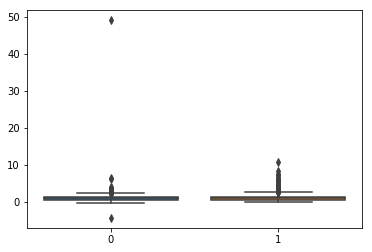

In [100]:
flat_list = []
selec_pro = []
non_sel_pro = []
for i in range(len(pair_df_image)):
    sublist = pair_df_image['FirstImageChange'].iloc[i]
    prolist = pair_df_image['NetOrganicToAVG'].iloc[i]
    for j in range(len(sublist)):
        item = sublist[j]
        if isinstance(item, int):
            flat_list.append(item)
            if item==1:
                selec_pro.append(prolist[j+1])
            else:
                non_sel_pro.append(prolist[j+1])
        else:
            print(item)
        
print(sum(flat_list)/len(flat_list))

print('Average organic profit (% to average value) when changing first image {}, number of samples {}'.format(np.mean(selec_pro), len(selec_pro)))
print('Average organic profit (% to average value) without changing first image {}, number of samples {}'.format(np.mean(non_sel_pro), len(non_sel_pro)))

sns.boxplot(data=[non_sel_pro, selec_pro])

## 65.4% of the image modification changed the first picture

In [62]:
pair_df_image['OnlyFirstImageChange'] = pair_df_image['ImagesNums'].apply(lambda x:check_only_1st_fig_change(x)) 
flat_list = []
for sublist in list(pair_df_image['FigSwitch']):
    for item in sublist:
        if isinstance(item, int):
            flat_list.append(item)
        else:
            print(item)
        
print(sum(flat_list)/len(flat_list))

error
0.013328182344987444


## 1.33% of the image modification only changed the first picture

In [49]:
pair_df_image['NumImageChange'] = pair_df_image['ImagesNums'].apply(lambda x:check_num_fig_change(x)) 

error
0.11860150666409117
Average organic profit (% to average value) when changing number of figures 0.9485787629554391, number of samples 614
Average organic profit (% to average value) without changing number of figures 0.9509889312011789, number of samples 4563


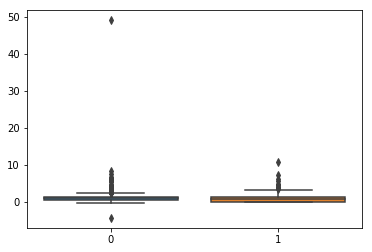

In [103]:
flat_list = []
selec_pro = []
non_sel_pro = []
for i in range(len(pair_df_image)):
    sublist = pair_df_image['NumImageChange'].iloc[i]
    prolist = pair_df_image['NetOrganicToAVG'].iloc[i]
    for j in range(len(sublist)):
        item = sublist[j]
        if isinstance(item, int):
            flat_list.append(item)
            if item==1:
                selec_pro.append(prolist[j+1])
            else:
                non_sel_pro.append(prolist[j+1])
        else:
            print(item)
        
print(sum(flat_list)/len(flat_list))

print('Average organic profit (% to average value) when changing number of figures {}, number of samples {}'.format(np.mean(selec_pro), len(selec_pro)))
print('Average organic profit (% to average value) without changing number of figures {}, number of samples {}'.format(np.mean(non_sel_pro), len(non_sel_pro)))

sns.boxplot(data=[non_sel_pro, selec_pro])

## 11.9% of the image modification changed the number of pictures

In [102]:
pair_df_image['FigSwitch'] = pair_df_image['ImagesNums'].apply(lambda x:check_fig_switch(x)) 
flat_list = []
for sublist in list(pair_df_image['FigSwitch']):
    for item in sublist:
        if isinstance(item, int):
            flat_list.append(item)
        else:
            print(item)
        
print(sum(flat_list)/len(flat_list))


error
0.013328182344987444


## 1.3% of the image modification switched other existing images to the first figure

In [54]:
pair_df_image['NumFig'] = pair_df_image['ImagesNums'].apply(lambda x:count_num_fig(x))
flat_list = []
for sublist in list(pair_df_image['NumFig']):
    for item in sublist:
        if isinstance(item, int):
            flat_list.append(item)
        else:
            print(item)
        
print(np.mean(flat_list))

error
6.980459141842033


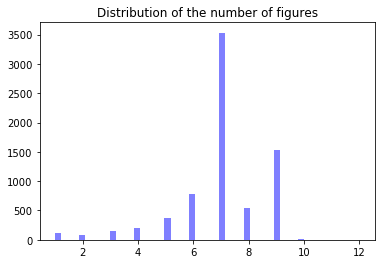

In [55]:
n, bins, patches = plt.hist(flat_list, 50, facecolor='blue', alpha=0.5)
plt.title('Distribution of the number of figures')
plt.show()

## On average, each asin has 6.98 images

In [104]:
# pair_df_image.to_csv('listing_dojo_image.csv', index=False)

In [111]:
pair_df_image['ASIN'] = pair_df_image['id'].apply(lambda x:x.split('_')[2])
def find_asin_category(asin):
    asin_data = blob.GetLatestASINInfo(marketplace=marketplace,asin=asin)
    try:
        return asin_data['Category']
    except:
        return 'error'

pair_df_image['Category'] = pair_df_image['ASIN'].apply(lambda x:find_asin_category(x))

In [114]:
##### Calculate the variance of the Net Organic
pair_df_image['VarOfNetOrganicToAVG'] = pair_df_image['NetOrganicToAVG'].apply(lambda x:np.var(x))

In [116]:
for cat in pair_df_image['Category'].unique():
    if cat!='error':
        print(cat)
        sub_df = pair_df_image[pair_df_image['Category']==cat]
        print('Number of samples (rows): {}'.format(len(sub_df)))
        print('Average variance: {}'.format(np.mean(sub_df['VarOfNetOrganicToAVG'])))
        print('***********************************************************************')

Health & Household
Number of samples (rows): 155
Average variance: 0.3197876386180479
***********************************************************************
Sports & Outdoors
Number of samples (rows): 316
Average variance: 0.4793223599111145
***********************************************************************
Beauty & Personal Care
Number of samples (rows): 153
Average variance: 0.39311537535540503
***********************************************************************
Office Products
Number of samples (rows): 78
Average variance: 0.5181766372425027
***********************************************************************
Toys & Games
Number of samples (rows): 66
Average variance: 0.4926185719690389
***********************************************************************
Handmade Products
Number of samples (rows): 38
Average variance: 3.285536720355894
***********************************************************************
Tools & Home Improvement
Number of samples (rows): 81
Average 

## Some visulization of the image changes

['d7249cab-dffc-4bef-a09b-c8595eeb6cd4.jpg', '8e3f814f-af93-4f0f-b938-31f8dab4c2a1.jpg', 'f6954966-df3e-4826-8f9b-5147885efd41.jpg', '97c431f1-7053-40c9-92f5-070090530818.jpg', '9bc1b303-f859-4470-90f5-e95a55f78baa.jpg', 'eb175d23-cfc9-4b08-83d5-f33c6812723b.jpg', '078691f0-e163-4694-8e43-9ef86cbad4e3.jpg']


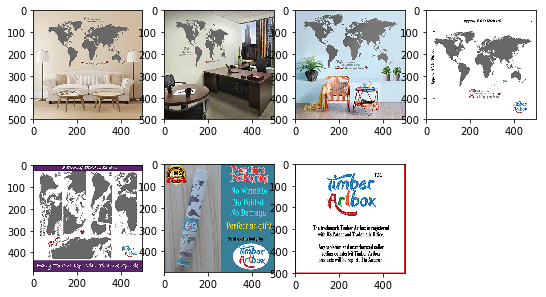

['51XZsx%2BuUCL.jpg', '51zTjfWSWML._SL75_.jpg', '51Z5s212A%2BL._SL75_.jpg', '4127tuDhNlL._SL75_.jpg', '51lIoj63JBL._SL75_.jpg', '51u2qH9z4FL._SL75_.jpg', '51Tx3Xmz3YL._SL75_.jpg']


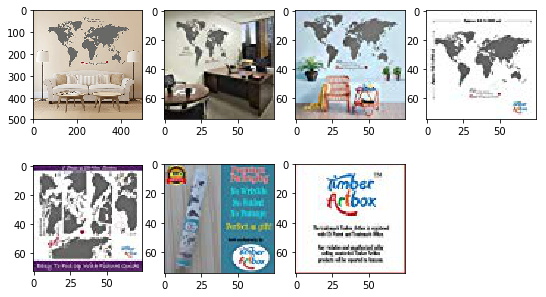

['51XZsx%2BuUCL.jpg', '51zTjfWSWML.jpg', '51Z5s212A%2BL.jpg', '4127tuDhNlL.jpg', '51lIoj63JBL.jpg', '51u2qH9z4FL.jpg', '51Tx3Xmz3YL.jpg']


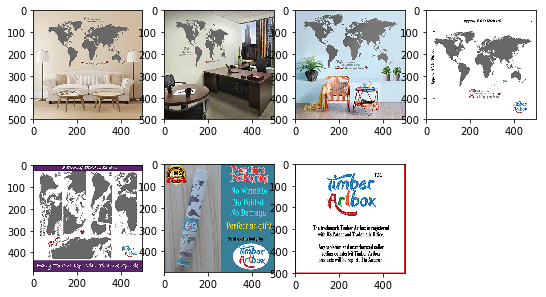

['51%2BLTSgtXiL.jpg', '51zTjfWSWML.jpg', '51Z5s212A%2BL.jpg', '4127tuDhNlL.jpg', '51lIoj63JBL.jpg', '51u2qH9z4FL.jpg', '51Tx3Xmz3YL.jpg']


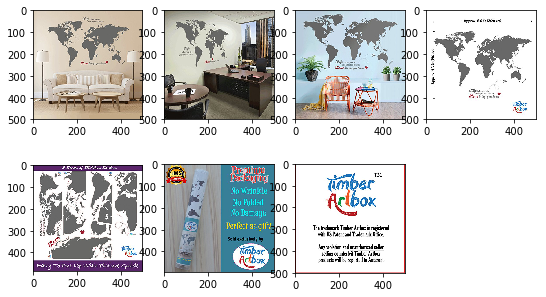

['51wu5prDaEL.jpg', '51%2BLTSgtXiL.jpg', '51eCMVBXT0L.jpg', '41h7bEKak3L.jpg', '51w%2Bh8MK-4L.jpg', '51qZVo0E-7L.jpg', '51deM6XLghL.jpg']


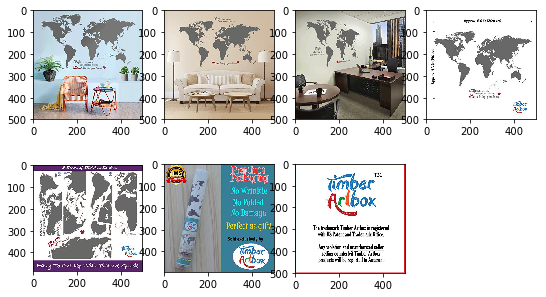

In [230]:
test_images = pair_df_image['Images'][0]

for opt in test_images:
    fig=plt.figure(figsize=(9, 8))
    print([st.split('/')[-1] for st in opt])
    for i in range(len(opt)):
        imgURL = opt[i]
        if 'https:/' not in imgURL:
            imgURL = 'https://images-na.ssl-images-amazon.com/images/I/' + imgURL
        response = requests.get(imgURL)
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(3, 4, i+1)
        imshow(np.asarray(img))
    show()

['4aa6a317-782d-4c7c-81f1-db9379115bf7.jpg', '7c3402f4-5ab1-4673-bb9c-f884d8f3506a.jpg', '2b2177e9-5cd7-4cf6-b820-e333d40ee739.jpg', '5ed6c1e1-7bf1-4617-b3cc-d62a2df4c9f8.jpg', '08abb918-3afc-47a0-b40f-d35e77a3113e.jpg', '23d240e6-da23-42c5-8666-7c29972f9db4.jpg', 'dfe307f6-593c-4b44-8373-14dbd3764351.jpg']


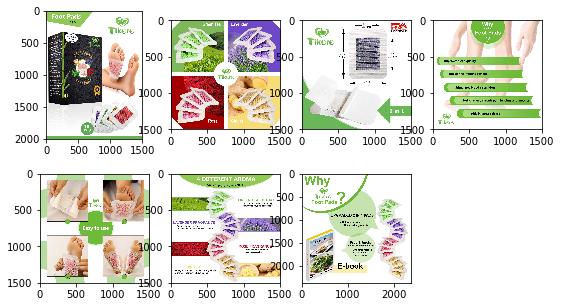

['715NZ8-akoL.jpg', '81OrXvpxupL.jpg', '71vgOm7boEL.jpg', '61IQ8WEhZFL.jpg', '717AauBFQML.jpg', '71NlRKk1K5L.jpg', '81RAIsgv3TL.jpg']


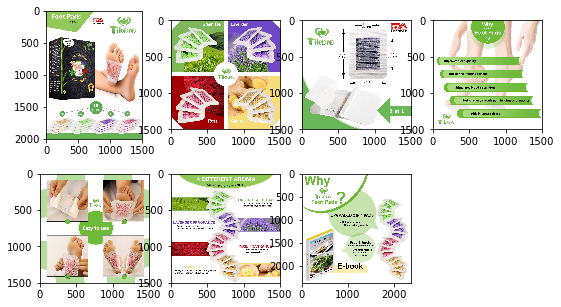

['81gp-zI1LkL.jpg', '81OrXvpxupL.jpg', '71vgOm7boEL.jpg', '61IQ8WEhZFL.jpg', '717AauBFQML.jpg', '71NlRKk1K5L.jpg', '81RAIsgv3TL.jpg']


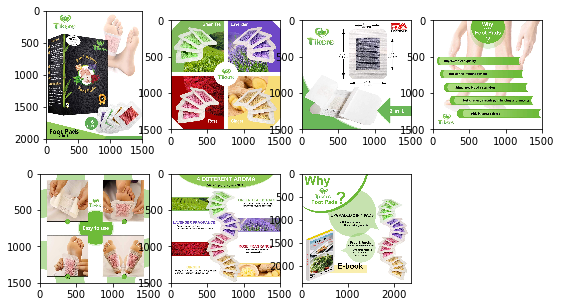

In [237]:
test_images = pair_df_image['Images'][2]

for opt in test_images:
    fig=plt.figure(figsize=(9, 8))
    print([st.split('/')[-1] for st in opt])
    for i in range(len(opt)):
        imgURL = opt[i]
        if 'https:/' not in imgURL:
            imgURL = 'https://images-na.ssl-images-amazon.com/images/I/' + imgURL
        response = requests.get(imgURL)
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(3, 4, i+1)
        imshow(np.asarray(img))
    show()

['af269155-f312-481e-a263-f79edb62f273.jpg', '6476d902-96d4-4cd5-9889-d69daaa17718.jpg', '750c289b-bb8b-403e-acc4-b514309a1534.jpg', '4049b9f3-f014-4af2-8dce-3a8d0431e09c.jpg', 'fca111d8-9d3b-42cb-b3c4-73409168fc45.jpg', '8ef12e0b-dc9f-4578-81fd-278c824857a8.jpg', '989d7e77-0950-4741-a5b0-ec89fae47b1d.jpg']


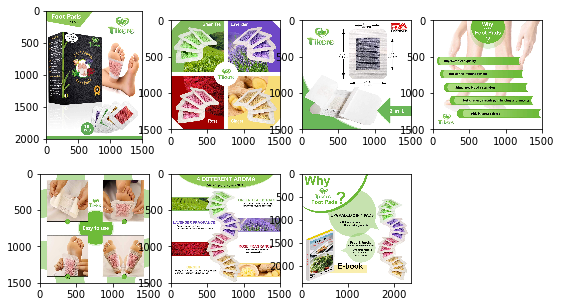

['71W3kT%2Bo31L.jpg', '81OrXvpxupL.jpg', '71vgOm7boEL.jpg', '61IQ8WEhZFL.jpg', '717AauBFQML.jpg', '71NlRKk1K5L.jpg', '81RAIsgv3TL.jpg']


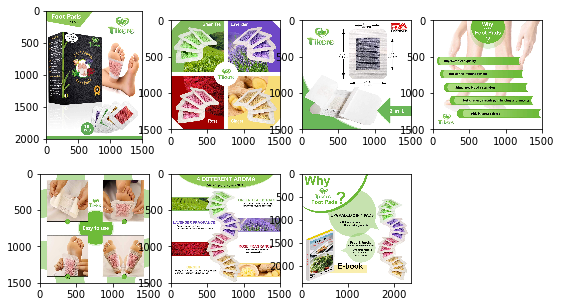

['81YPV364GxL.jpg', '817yBWNRo0L.jpg', '71cuncsABnL.jpg', '61o8Cp6jKhL.jpg', '710vxI9wS7L.jpg', '71KwCiWCo1L.jpg', '8169Z9FfqtL.jpg']


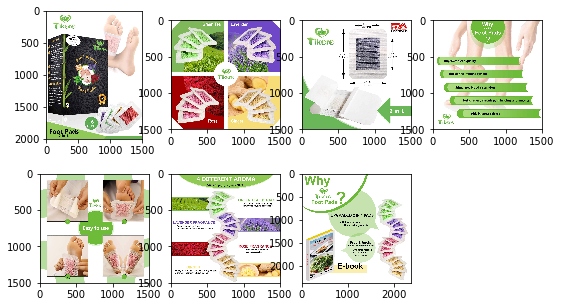

['71xJTq8l1TL.jpg', '817yBWNRo0L.jpg', '71cuncsABnL.jpg', '61o8Cp6jKhL.jpg', '710vxI9wS7L.jpg', '71KwCiWCo1L.jpg', '8169Z9FfqtL.jpg']


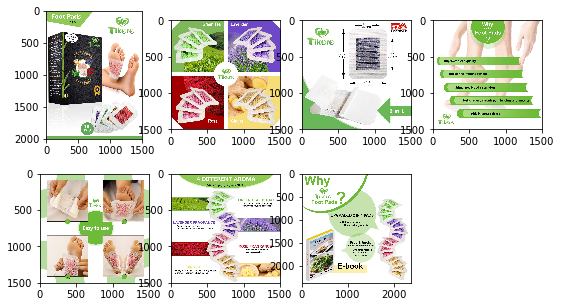

In [239]:
test_images = pair_df_image['Images'][3]

for opt in test_images:
    fig=plt.figure(figsize=(9, 8))
    print([st.split('/')[-1] for st in opt])
    for i in range(len(opt)):
        imgURL = opt[i]
        if 'https:/' not in imgURL:
            imgURL = 'https://images-na.ssl-images-amazon.com/images/I/' + imgURL
        response = requests.get(imgURL)
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(3, 4, i+1)
        imshow(np.asarray(img))
    show()

['2e131bba-d4b1-403e-a5e4-846f55d79e9b.jpg', 'f6dfd006-4104-4962-801d-573874f82519.jpg', '77ea5f4b-5f16-4527-b15f-d7b13266d51e.jpg', 'abd3b1a0-49de-46dc-8e80-01e80fce7763.jpg', 'a2b8f931-3ae2-4fc2-b59e-d6c2910f727b.jpg', 'fcd570e7-f595-4e55-89f1-4ba05fd6b225.jpg', 'ab15576e-4c90-4d81-85e7-d3bf9e33675e.jpg']


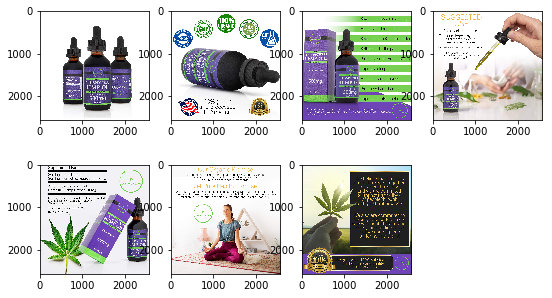

['81R0AdcrJVL.jpg', '91ckBVx0SRL.jpg', '91qfkFCdFhL.jpg', '813TtioMZTL.jpg', '91fGZl7NeXL.jpg', '91U3K0fYZxL.jpg', '911oHnFqE9L.jpg']


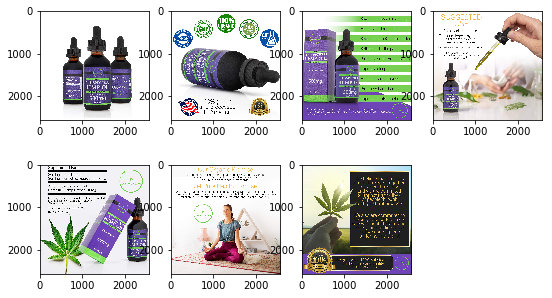

['81aaOkWKjTL.jpg', '91WFgidQ5eL.jpg', '91LGPDTtUVL.jpg', '81mwGDQHMvL.jpg', '913tIUjYQoL.jpg', '91QAzXhdCUL.jpg', '91ZlEdE-JaL.jpg']


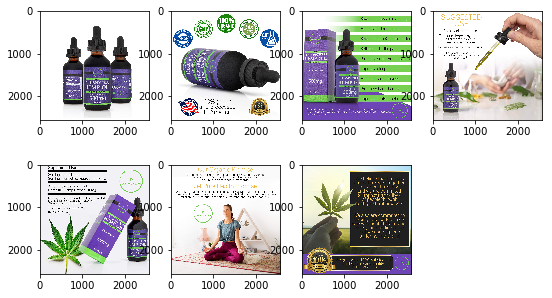

['91Ev8aS1lPL.jpg', '91WFgidQ5eL.jpg', '91LGPDTtUVL.jpg', '81mwGDQHMvL.jpg', '913tIUjYQoL.jpg', '91QAzXhdCUL.jpg', '91ZlEdE-JaL.jpg']


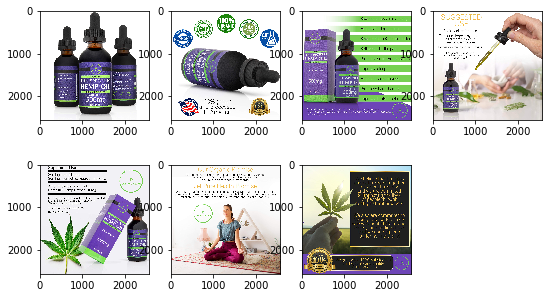

['811sVlID8aL.jpg', '91WFgidQ5eL.jpg', '91LGPDTtUVL.jpg', '81mwGDQHMvL.jpg', '913tIUjYQoL.jpg', '91Ev8aS1lPL.jpg', '91ZlEdE-JaL.jpg']


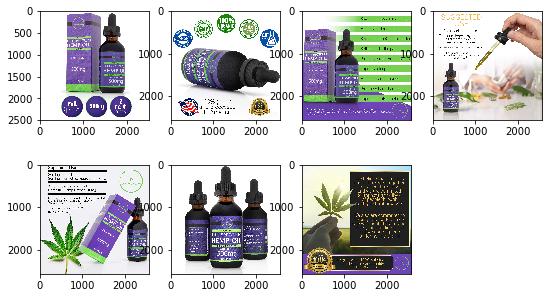

['811sVlID8aL.jpg', '91WFgidQ5eL.jpg', '91LGPDTtUVL.jpg', '81mwGDQHMvL.jpg', '913tIUjYQoL.jpg', '81787fgA21L.jpg', '91ZlEdE-JaL.jpg']


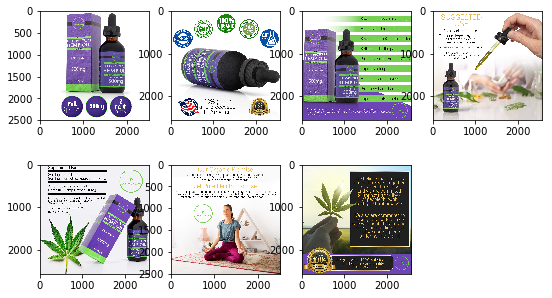

['91z6avIcJFL.jpg', '91WFgidQ5eL.jpg', '91LGPDTtUVL.jpg', '81mwGDQHMvL.jpg', '913tIUjYQoL.jpg', '91Ev8aS1lPL.jpg', '91ZlEdE-JaL.jpg']


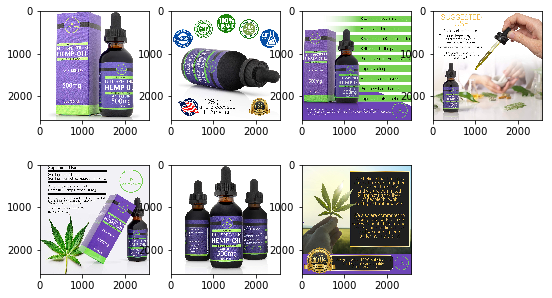

['81aaOkWKjTL.jpg', '91WFgidQ5eL.jpg', '91LGPDTtUVL.jpg', '811wgj1Hq0L.jpg', '913tIUjYQoL.jpg', '813TtioMZTL.jpg', '91ZlEdE-JaL.jpg']


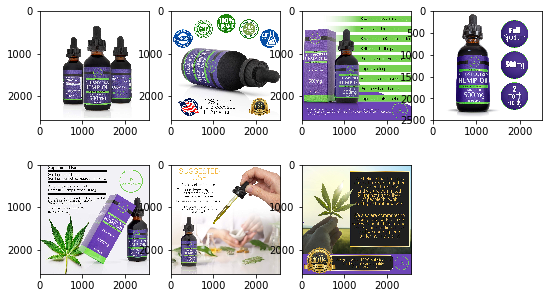

['91z6avIcJFL.jpg', '91WFgidQ5eL.jpg', '91LGPDTtUVL.jpg', '91Ev8aS1lPL.jpg', '913tIUjYQoL.jpg', '811wgj1Hq0L.jpg', '91ZlEdE-JaL.jpg']


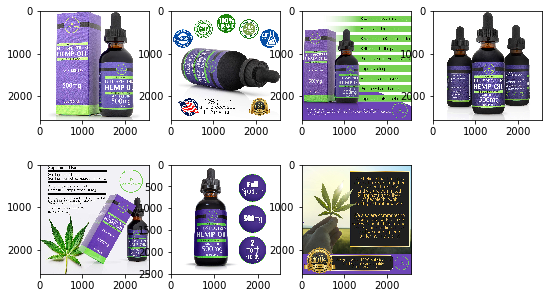

In [248]:
test_images = pair_df_image['Images'][66]

for opt in test_images:
    fig=plt.figure(figsize=(9, 8))
    print([st.split('/')[-1] for st in opt])
    for i in range(len(opt)):
        imgURL = opt[i]
        if 'https:/' not in imgURL:
            imgURL = 'https://images-na.ssl-images-amazon.com/images/I/' + imgURL
        response = requests.get(imgURL)
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(3, 4, i+1)
        imshow(np.asarray(img))
    show()

['db377b3a-efc9-474f-96ce-8c8a2cd3eb19.jpg', '0a13ef34-2e54-45d8-b87d-91b9f2cd6c91.jpg', '83fde4cf-f620-4fcc-b958-f0d00a5568e5.jpg', 'f86faf64-0b21-495f-a0b6-a3e13a3f1227.jpg', 'd6cffd5f-a78a-4a9b-96c0-7c40d41460de.jpg', '70a320a1-03ee-400d-90cb-7bfa42f8a82a.jpg', '6d180e0c-c4ae-4c41-b7b6-c1f66d11baae.jpg', '37ae2615-15d3-41d2-a7ab-156516879909.jpg', '41704def-2fe8-453f-b4b7-a7cb728ef428.jpg']


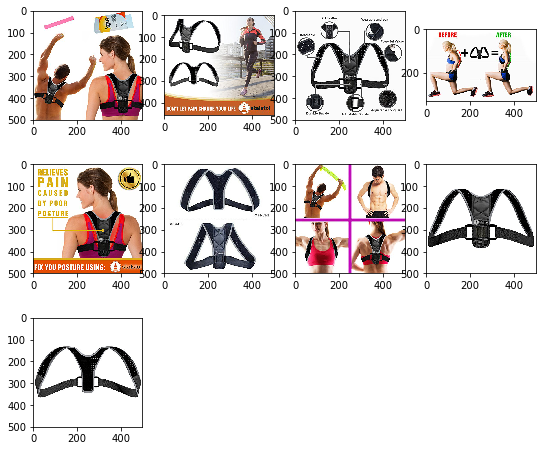

['517HKv9owkL.jpg', '514BU%2BE6pqL.jpg', '51iMpb9zYBL.jpg', '41zwSTzYWpL.jpg', '51GblPX0eoL.jpg', '51JA6-cs3mL.jpg', '5160Bny-mUL.jpg', '51ERFLAMmZL.jpg', '41b9aydHGwL.jpg']


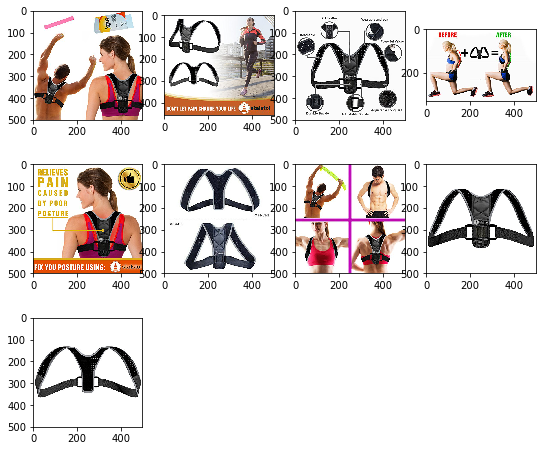

['51rtd88VTaL.jpg', '51cXWc0fi9L.jpg', '51U5rN7eDHL.jpg', '41Dx3rBiUNL.jpg', '51EAEMAzhfL.jpg', '514pusWMRsL.jpg', '51ilkErgcKL.jpg', '51o0Zf7Q4bL.jpg', '41TWOFANWKL.jpg']


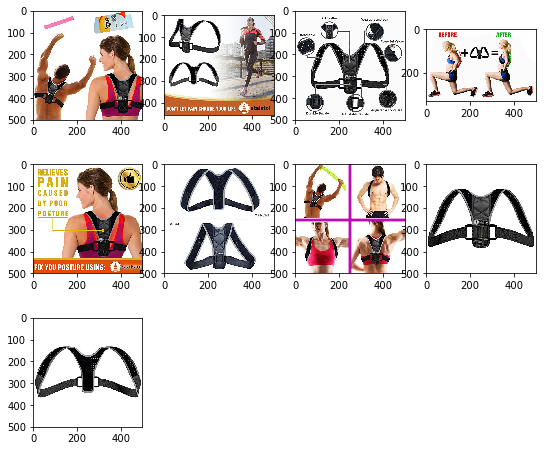

['51rkDOWdPnL.jpg', '51cXWc0fi9L.jpg', '51U5rN7eDHL.jpg', '41Dx3rBiUNL.jpg', '51EAEMAzhfL.jpg', '514pusWMRsL.jpg', '51ilkErgcKL.jpg', '51o0Zf7Q4bL.jpg', '41TWOFANWKL.jpg']


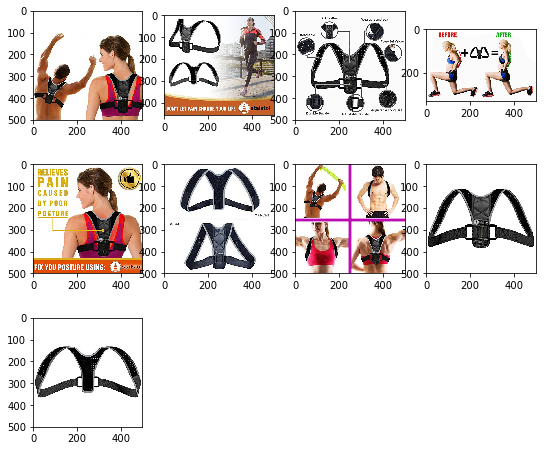

['517HKv9owkL.jpg', '51cXWc0fi9L.jpg', '51U5rN7eDHL.jpg', '41Dx3rBiUNL.jpg', '51EAEMAzhfL.jpg', '514pusWMRsL.jpg', '51ilkErgcKL.jpg', '51o0Zf7Q4bL.jpg', '41TWOFANWKL.jpg']


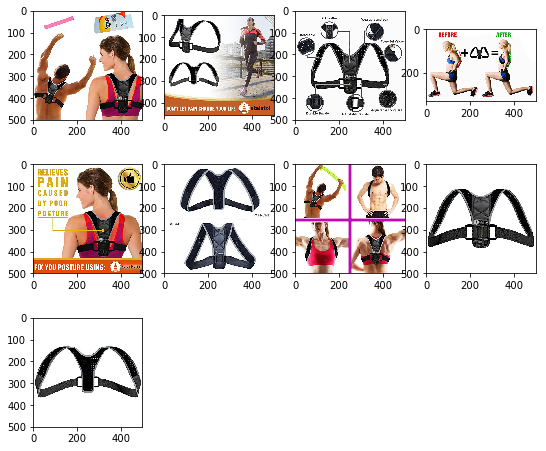

In [242]:
test_images = pair_df_image['Images'][6]

for opt in test_images:
    fig=plt.figure(figsize=(9, 8))
    print([st.split('/')[-1] for st in opt])
    for i in range(len(opt)):
        imgURL = opt[i]
        if 'https:/' not in imgURL:
            imgURL = 'https://images-na.ssl-images-amazon.com/images/I/' + imgURL
        response = requests.get(imgURL)
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(3, 4, i+1)
        imshow(np.asarray(img))
    show()

['bf978c2a-be50-46b9-92f3-5c959579ba9e.jpg', 'e10516bc-bfa9-4b41-ac51-440ef74a0021.jpg', '8b00aecf-3f71-4a6b-a276-72c65ad170ba.jpg', '242c8aa8-dfc9-4ce4-b7c0-da2701cc9ffe.jpg', '7a78ae57-2c8f-475f-af03-a563eb69ef64.jpg', 'dfa71d96-d081-42cb-aa49-3702d480d8e9.jpg', '493c0d6e-b727-434a-ae99-ba8163e8a09a.jpg', '59daf5d1-c8ce-4ef8-91e0-b6b327f4bd07.jpg', 'e9808560-c751-4b76-b091-06c7478e0e5b.jpg']


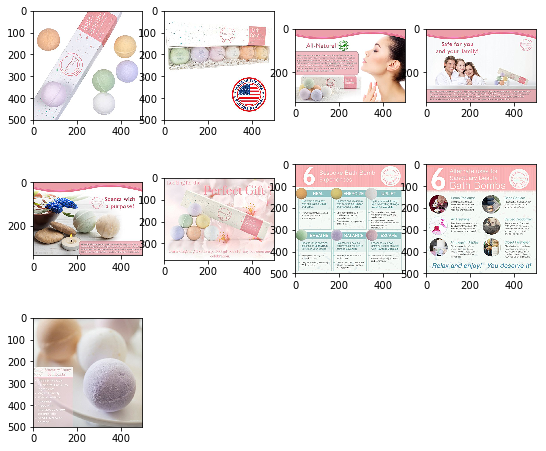

['519NG%2BZYV8L.jpg', '51dEMmnrKjL.jpg', '51vED7PYjFL.jpg', '41ji1gW-6ML.jpg', '51KkIec5eYL.jpg', '41zw1JO3DbL.jpg', '51bF3vp4HbL.jpg', '61EQn8%2BBMVL.jpg', '41SQ6aBe3NL.jpg']


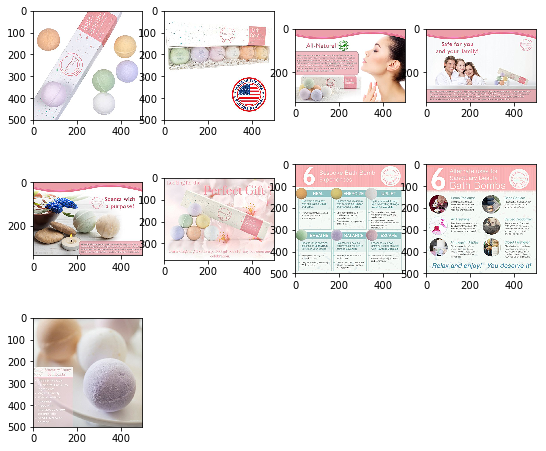

['51HA7lUFy7L.jpg', '51D6IJA8pyL.jpg', '51W6dFbc2%2BL.jpg', '41WUeFo3PRL.jpg', '51V6GTVNy5L.jpg', '41ztEX9vGsL.jpg', '51kLpy-%2BmpL.jpg', '61vb5JilhdL.jpg', '41cBgO-MiBL.jpg']


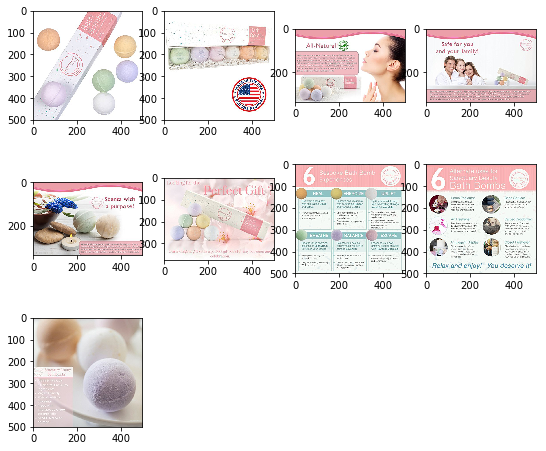

['51HA7lUFy7L.jpg', '51Fx3%2BhG94L.jpg', '51MTvTfjy8L.jpg', '41U-wMXHhJL.jpg', '5149uE54cOL.jpg', '51ZcJzePSZL.jpg', '51kLpy-%2BmpL.jpg', '61vb5JilhdL.jpg', '41cBgO-MiBL.jpg']


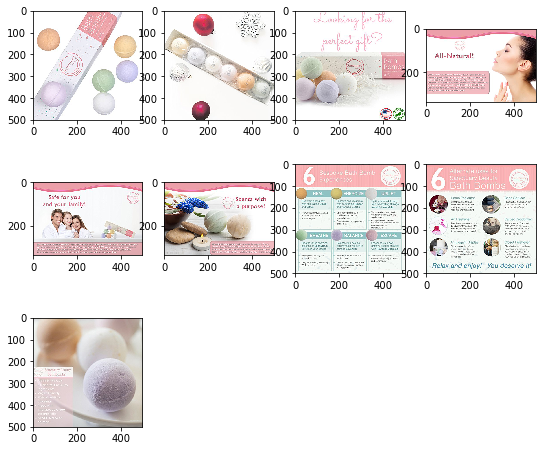

In [243]:
test_images = pair_df_image['Images'][7]

for opt in test_images:
    fig=plt.figure(figsize=(9, 8))
    print([st.split('/')[-1] for st in opt])
    for i in range(len(opt)):
        imgURL = opt[i]
        if 'https:/' not in imgURL:
            imgURL = 'https://images-na.ssl-images-amazon.com/images/I/' + imgURL
        response = requests.get(imgURL)
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(3, 4, i+1)
        imshow(np.asarray(img))
    show()

['238ded66-210b-442d-860f-a48aa8ce4ab1.jpg', '975d1d44-4798-4f2e-b536-bed80f7dfaf8.jpg', 'd213c107-500a-4019-8be0-7d7af15b746f.jpg', 'd739af2c-bccd-4626-8df5-7a6d3e4faf87.jpg', '6be3c306-26c8-470c-a32f-e12746f46155.jpg', '94177f8f-d9e6-4b78-b205-df5cabd90bd2.jpg']


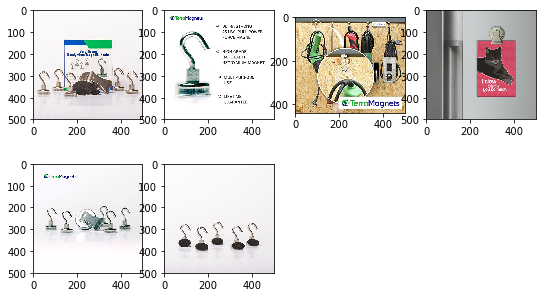

['41FKQASV5ZL.jpg', '41mwfPB4oDL.jpg', '61UK4NQ%2B7uL.jpg', '41HcOvqOZyL.jpg', '41DdrRsG7nL.jpg', '41HxUNY7epL.jpg']


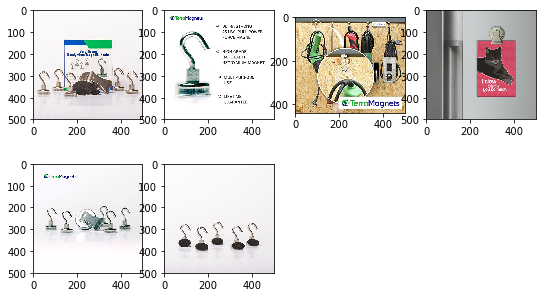

In [244]:
test_images = pair_df_image['Images'][8]

for opt in test_images:
    fig=plt.figure(figsize=(9, 8))
    print([st.split('/')[-1] for st in opt])
    for i in range(len(opt)):
        imgURL = opt[i]
        if 'https:/' not in imgURL:
            imgURL = 'https://images-na.ssl-images-amazon.com/images/I/' + imgURL
        response = requests.get(imgURL)
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(3, 4, i+1)
        imshow(np.asarray(img))
    show()

['958318f8-f572-4cb6-824e-fd01cef717b8.jpg', '1a749df0-83c5-4020-b50a-c0c96799bcbc.jpg', '24182bc4-ecdb-4ff8-a896-d7464c3e6726.jpg', '16c0cecb-b8f9-47ca-bc63-2ff57ca525dd.jpg', 'fcdc4e86-85e4-4f2a-8292-b4c066015886.jpg', '369039b9-be10-46d5-a2f5-93ad6f630687.jpg', '535b766f-beb8-4170-8849-ac0e8c86af74.jpg']


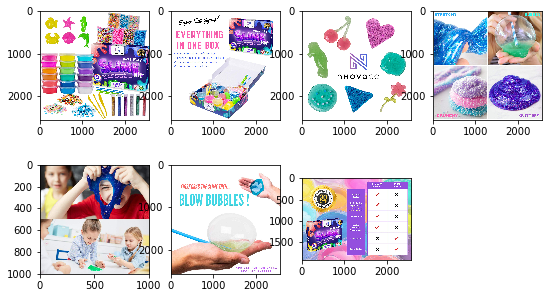

['91Ahs4LxNRL.jpg', '81uLAmwyeVL.jpg', '81M08GBEzfL.jpg', '91Bampd4BRL.jpg', '612GXLb4QmL.jpg', '81%2BhJG9KS-L.jpg', '81PZ-ByC4bL.jpg']


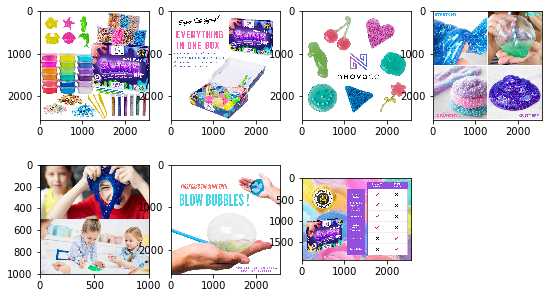

In [245]:
test_images = pair_df_image['Images'][9]

for opt in test_images:
    fig=plt.figure(figsize=(9, 8))
    print([st.split('/')[-1] for st in opt])
    for i in range(len(opt)):
        imgURL = opt[i]
        if 'https:/' not in imgURL:
            imgURL = 'https://images-na.ssl-images-amazon.com/images/I/' + imgURL
        response = requests.get(imgURL)
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(3, 4, i+1)
        imshow(np.asarray(img))
    show()

In [190]:
total_len = len(pair_df_price) + len(pair_df_image) + len(pair_df_title) + len(pair_df_desc)
print('Option of change: Price')
print('Total number of cases: {}, percentage: {}%'.format(len(pair_df_price), round(len(pair_df_price)/total_len*100)))
print('Average variance of net total: {}'.format(np.mean(pair_df_price['VarianceOfNetTotalPCT'][pair_df_price['VarianceOfNetTotalPCT']<=1])))
print('-----------------------------------------------')
print('Option of change: Images')
print('Total number of cases: {}, percentage: {}%'.format(len(pair_df_image), round(len(pair_df_image)/total_len*100)))
print('Average variance of net total: {}'.format(np.mean(pair_df_image['VarianceOfNetTotalPCT'][pair_df_image['VarianceOfNetTotalPCT']<=1])))
print('-----------------------------------------------')
print('Option of change: Title')
print('Total number of cases: {}, percentage: {}%'.format(len(pair_df_title), round(len(pair_df_title)/total_len*100)))
print('Average variance of net total: {}'.format(np.mean(pair_df_title['VarianceOfNetTotalPCT'][pair_df_title['VarianceOfNetTotalPCT']<=1])))
print('-----------------------------------------------')
print('Option of change: Description')
print('Total number of cases: {}, percentage: {}%'.format(len(pair_df_desc), round(len(pair_df_desc)/total_len*100)))
print('Average variance of net total: {}'.format(np.mean(pair_df_desc['VarianceOfNetTotalPCT'][pair_df_desc['VarianceOfNetTotalPCT']<=1])))
print('-----------------------------------------------')

Option of change: Price
Total number of cases: 4964, percentage: 51%
Average variance of net total: 0.1385383295752597
-----------------------------------------------
Option of change: Images
Total number of cases: 2365, percentage: 24%
Average variance of net total: 0.165732237060191
-----------------------------------------------
Option of change: Title
Total number of cases: 1789, percentage: 18%
Average variance of net total: 0.11204027877952204
-----------------------------------------------
Option of change: Description
Total number of cases: 590, percentage: 6%
Average variance of net total: 0.11560019971389267
-----------------------------------------------


In [121]:
price_pct_ls = []
net_total_pct_ls = []
for d in pair_ls:
    price_pct_ls = price_pct_ls + d['PercentPriceChange']
    net_total_pct_ls = net_total_pct_ls + d['PercentNetTotalChange']

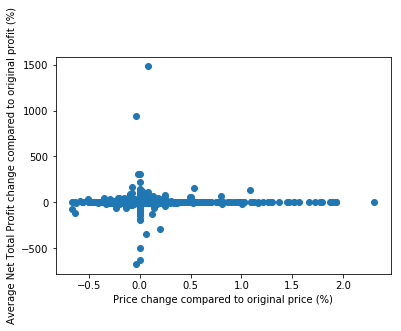

In [122]:
plt.scatter(price_pct_ls, net_total_pct_ls)
plt.xlabel('Price change compared to original price (%)')
plt.ylabel('Average Net Total Profit change compared to original profit (%)')
plt.show()

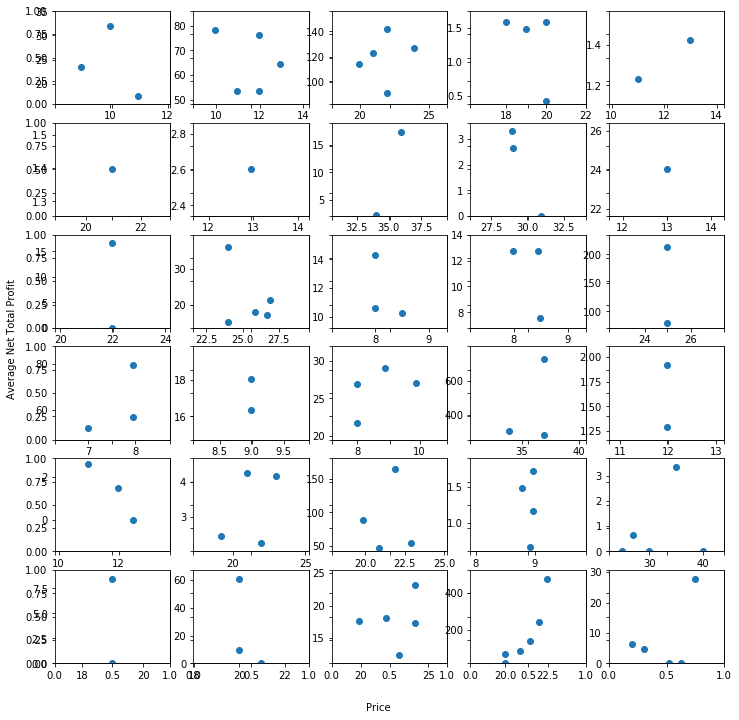

In [160]:
####### Some plots about the price change vs the change of net total profit

%matplotlib inline
# plt.figure(figsize=(12, 12))
fig, axes = plt.subplots(6, 5, sharex=True, sharey=True, figsize=(12, 12))
# fig, axes = plt.subplots(6, 5, figsize=(12, 12))
for i in range(30):
    d = pair_ls[i]
    p = d['Price']
    pro = d['AverageNetTotal']
    fig.add_subplot(6, 5, i+1, frameon=True)
#     plt.subplot(6, 5, i+1)
    plt.xlim(min(p)*0.9, max(p)*1.1)
    plt.ylim(min(pro)*0.9, max(pro)*1.1)
    plt.scatter(p, pro)
    # hide tick and tick label of the big axes
#     plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
fig.text(0.5, 0.07, 'Price', ha='center')
fig.text(0.07, 0.5, 'Average Net Total Profit', va='center', rotation='vertical')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='major',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
#     plt.show()

In [118]:
import psutil
psutil.virtual_memory()

svmem(total=473389137920, available=282635816960, percent=40.3, used=188458561536, free=177558589440, active=228565143552, inactive=60072484864, buffers=2055004160, cached=105316982784, shared=189050880, slab=5834567680)